`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2022/2023`   




# Лабораторная работа №4: Методы снижения размерности. Регуляризация логистической регрессии. 
## Бобина Татьяна Сергеевна
### Вариант 1





## Загружаем пакеты

In [3]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  распределение Стьюдента для проверки значимости
from scipy.stats import t
# подсчёт частот внутри массива
from collections import Counter
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  стандартизация показателей
from sklearn.preprocessing import StandardScaler
#  метод главных компонент
from sklearn.decomposition import PCA
# метод частных наименьших квадратов
from sklearn.cross_decomposition import PLSRegression
#  логистическая регрессия (ММП)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
#  перекрёстная проверка по k блокам
from sklearn.model_selection import KFold, cross_val_score
#  расчёт Acc и сводка по точности классификации
from sklearn.metrics import accuracy_score, classification_report

In [4]:
# константы
#  ядро для генератора случайных чисел
my_seed = 1
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [5]:
# функция, которая строит график сжатия коэффициентов в ридж и лассо
#  из репозитория к книге С.Рашки Python и машинное обучение,
#  слегка переработанная
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names,
                        C_min_pow=-4, C_max_pow=3.) :
    fig = plt.figure()
    ax = plt.subplot(111)    
    
    # палитра
    colors = sns.color_palette("Spectral", len(col_names)-1)
    
    weights, params = [], []
    for c in np.arange(C_min_pow, C_max_pow+1):
        lr = LogisticRegression(penalty=penalty_name, 
                                C=10.**c, solver='liblinear', 
                                multi_class='ovr', random_state=my_seed)
        lr.fit(X, y)
        weights.append(lr.coef_[class_number])
        params.append(10**c)

    weights = np.array(weights)

    for column, color in zip(range(weights.shape[1]), colors):
        plt.plot(params, weights[:, column],
                 label=col_names[column],
                 color=color)

    # отсечки по оптимальным C
    plt.axvline(x=C_opt[class_number], color='magenta', 
                linestyle='--', linewidth=1)

    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10**(C_min_pow), 10**C_max_pow])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center', 
              bbox_to_anchor=(1.38, 1.03),
              ncol=1, fancybox=True)
    plt.show()

## Загружаем данные
Набор данных `winequality-red_for_lab` в формате .csv доступен для загрузки по адресу: <https://raw.githubusercontent.com/ania607/ML/main/data/winequality-red_for_lab.csv>. 

Загружаем данные во фрейм и выясняем их размерность.  

In [6]:
# читаем таблицу из файла .csv во фрейм
fileURL = 'https://raw.githubusercontent.com/ania607/ML/main/data/winequality-red_for_lab.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (1599, 13)


In [9]:
# оставляем в наборе данных только то, что нужно 
#  (плюс метки регионов для графиков)
DF_all = DF_raw[['citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 
                 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'Y']]

In [10]:
# удаляем фрейм-исходник
del DF_raw

Прежде чем переходить к анализу данных, разделим фрейм на две части: для построения 
моделей (85%) и отложенные наблюдения (15%).   

In [11]:
# наблюдения для моделирования
DF = DF_all.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_all.drop(DF.index)

In [12]:
# первые 5 строк фрейма у первых 7 столбцов
DF.iloc[:, :7].head(5)

,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH
75,0.64,2.2,0.093,9.0,42.0,0.99860,3.54
1283,0.28,2.7,0.096,17.0,69.0,0.99734,3.26
408,0.58,3.7,0.174,6.0,16.0,0.99700,3.19
1281,0.20,1.9,0.077,28.0,54.0,0.99560,3.37
1118,0.12,2.1,0.065,14.0,24.0,0.99252,3.30


In [13]:
# первые 5 строк фрейма у столбцов 8-11
DF.iloc[:, 7:11].head(5)

,sulphates,alcohol,Y
75,0.66,10.5,0
1283,0.63,10.2,1
408,0.70,11.3,1
1281,0.64,10.4,1
1118,0.53,13.3,1


In [14]:
# типы столбцов фрейма
DF.dtypes

citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
Y                         int64
dtype: object

Проверим, нет ли в таблице пропусков.  

In [15]:
# считаем пропуски в каждом столбце
DF.isna().sum()

citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
Y                       0
dtype: int64

Пропусков не обнаружено.  

# Предварительный анализ данных  

## Описательные статистики  

Считаем доли классов целевой переменной `Y`.  

In [16]:
# метки классов
DF.Y.unique()

array([0, 1], dtype=int64)

In [17]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 3)

1    0.536
0    0.464
Name: Y, dtype: float64

Все объясняющие переменные набора данных непрерывные. Рассчитаем для них описательные статистики.  

In [18]:
# описательные статистики
DF.iloc[:, :6].describe()

,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,0.270338,2.517991,0.087855,15.948492,46.684695,0.996751
std,0.194694,1.382336,0.048463,10.462022,32.848989,0.001891
min,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070
25%,0.090000,1.900000,0.070000,7.000000,22.000000,0.995610
50%,0.260000,2.200000,0.079000,14.000000,38.000000,0.996720
75%,0.420000,2.600000,0.090000,22.000000,63.000000,0.997825
max,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690


In [19]:
# описательные статистики
DF.iloc[:, 6:9].describe()

,pH,sulphates,alcohol
count,1359.000000,1359.000000,1359.000000
mean,3.307851,0.659051,10.406672
std,0.152771,0.170558,1.065804
min,2.740000,0.370000,8.400000
25%,3.210000,0.550000,9.500000
50%,3.310000,0.620000,10.100000
75%,3.400000,0.730000,11.100000
max,4.010000,2.000000,14.900000


Выводы по описательным статистикам: значения объясняющих переменных положительные, масштабы измерения отличаются. Для работы с методами снижения размерности и регуляризации понадобится стандартизация значений.   

## Визуализация разброса переменных внутри классов  

В наборе данных 9 объясняющих переменных, и все они непрерывные. Построим коробчатые диаграммы для объясняющих переменных, чтобы сравнить средние уровни и разброс по классам.  

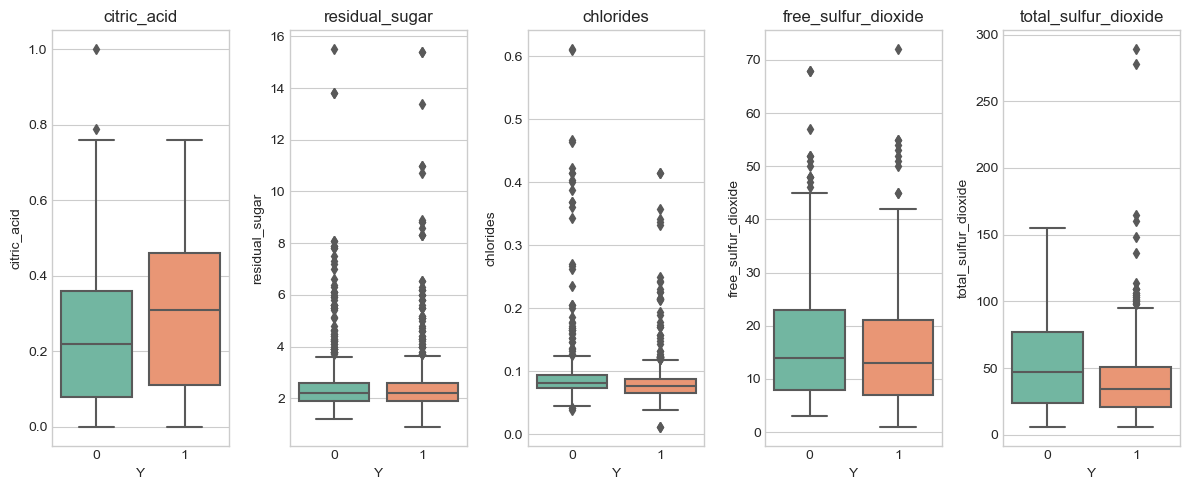

In [20]:
# создаём полотно и делим его на части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[:5].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

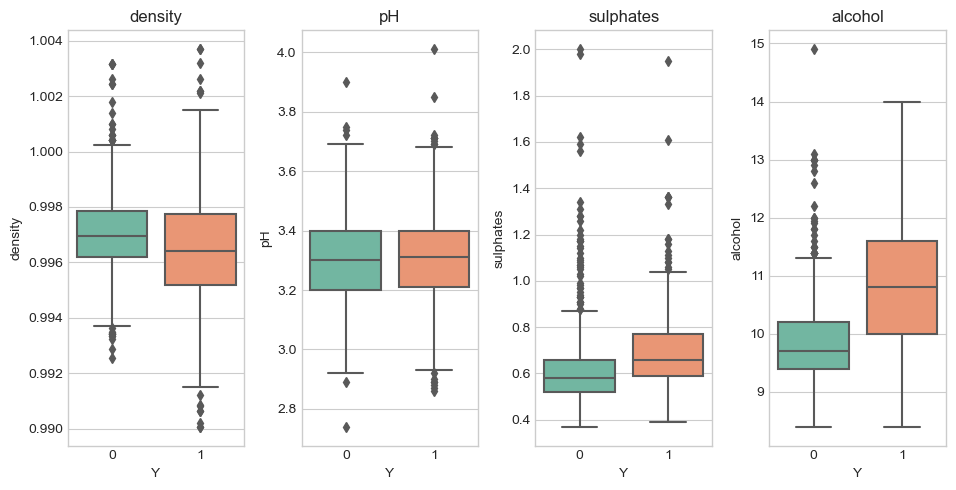

In [21]:
# создаём полотно и делим его на части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])


axs = [ax1, ax2, ax3, ax4]

cols_loop = list(DF.columns[5:9].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

На графиках отличие в медианах и разбросе между классами прослеживается по многим объясняющим переменным. Меньше всего различаются коробчатые диаграммы по переменной `residual_sugar, chlorides, free_sulfur_dioxide, pH`. 
Это говорит о том, классы по зависимой переменной `Y` неплохо разделяются по всем остальным `citric_acid, total_sulfur_dioxide, density, sulphates, alcohol` объясняющим переменным.  

## Корреляционный анализ   

Теперь посмотрим на взаимодействие объясняющих переменных.  

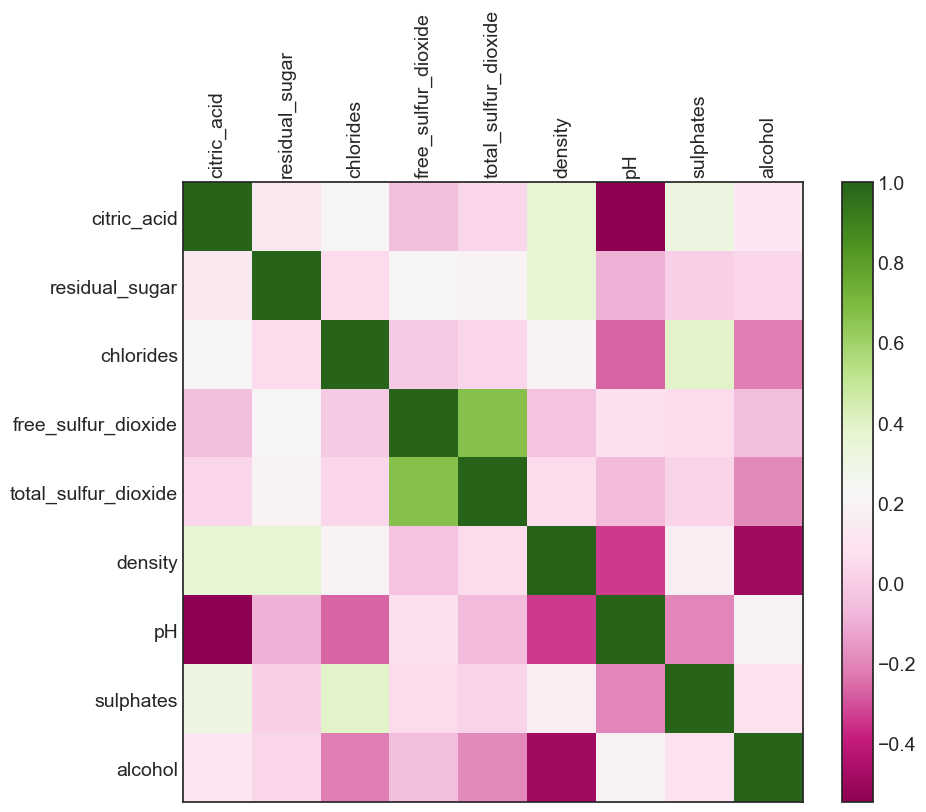

In [22]:
# рассчитываем корреляционную матрицу
corr_mat = DF.drop('Y', axis=1).corr()
col_names = DF.drop('Y', axis=1).columns

# переключаем стиль оформления, чтобы убрать сетку с тепловой карты
mpl.style.use('seaborn-white')

# рисуем корреляционную матрицу
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='PiYG')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

Между объясняющими переменными обнаруживаются как прямые, так и обратные линейные взаимосвязи. Выведем все значимые коэффициенты в одной таблице и определим минимальный / максимальный из них.     

In [23]:
# делаем фрейм из корреляционной матрицы и стираем диагональные значения
#  и нижний треугольник матрицы
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
# меняем размерность с матрицы на таблицу: показатель 1, показатель 2,
#  корреляция
df = df.stack().reset_index()
df.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']
# считаем двусторонние p-значения для проверки значимости
t_stat = np.sqrt((len(DF.index) - 2) / (1 - df.Корреляция ** 2))
df['P_значение'] = 2 * (1 - t.cdf(abs(t_stat), len(DF.index) - 2))
# получили все корреляционные коэффициенты без 1 и без повторов
#  выводим все значимые с сортировкой
df.loc[df['P_значение'] < 0.05].sort_values('Корреляция')

,Показатель_1,Показатель_2,Корреляция,P_значение
5,citric_acid,pH,-0.546355,0.0
32,density,alcohol,-0.490942,0.0
30,density,pH,-0.335058,0.0
18,chlorides,pH,-0.264044,0.0
20,chlorides,alcohol,-0.216241,0.0
33,pH,sulphates,-0.196255,0.0
29,total_sulfur_dioxide,alcohol,-0.189917,0.0
12,residual_sugar,pH,-0.090467,0.0
27,total_sulfur_dioxide,pH,-0.060618,0.0
25,free_sulfur_dioxide,alcohol,-0.051912,0.0


# Методы снижения размерности  

Посмотрим, как работает метод снижения размерности:  

* регрессия на главные компоненты (PCR)   

Метод требует предварительной стандартизации переменных.  

In [24]:
# стандартизация
sc = StandardScaler()
X_train_std = sc.fit_transform(DF.iloc[:, :9].values)

# проверяем средние и стандартные отклонения после стандартизации
for i_col in range(X_train_std.shape[1]) :
    print('Столбец ', i_col, ': среднее = ',
          np.round(np.mean(X_train_std[:, i_col]), 2),
         '   Станд. отклонение = ', 
          np.round(np.std(X_train_std[:, i_col]), 2), sep='')

Столбец 0: среднее = 0.0   Станд. отклонение = 1.0
Столбец 1: среднее = -0.0   Станд. отклонение = 1.0
Столбец 2: среднее = 0.0   Станд. отклонение = 1.0
Столбец 3: среднее = -0.0   Станд. отклонение = 1.0
Столбец 4: среднее = 0.0   Станд. отклонение = 1.0
Столбец 5: среднее = -0.0   Станд. отклонение = 1.0
Столбец 6: среднее = 0.0   Станд. отклонение = 1.0
Столбец 7: среднее = -0.0   Станд. отклонение = 1.0
Столбец 8: среднее = 0.0   Станд. отклонение = 1.0


## Регрессия на главные компоненты (PCR)  

Пересчитаем объясняющие показатели в главные компоненты.  

In [25]:
# функция с методом главных компонент
pca = PCA()
# пересчитываем в главные компоненты (ГК)
X_train_pca = pca.fit_transform(X_train_std)

# считаем доли объяснённой дисперсии
frac_var_expl = pca.explained_variance_ratio_
print('Доли объяснённой дисперсии по компонентам в PLS:\n',
     np.around(frac_var_expl, 3),
     '\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PLS:
 [0.265 0.197 0.146 0.122 0.098 0.068 0.047 0.035 0.023] 
Общая сумма долей: 1.0


Главные компоненты взаимно ортогональны, убедимся в этом.  

In [26]:
# ГК ортогональны – убедимся в этом, рассчитыв корреляционную матрицу
corr_mat = pd.DataFrame(X_train_pca).corr()
np.around(corr_mat, 2)

,0,1,2,3,4,5,6,7,8
0,1.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0
1,-0.0,1.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,-0.0,0.0,-0.0,-0.0,0.0,0.0
3,0.0,-0.0,-0.0,1.0,-0.0,0.0,0.0,-0.0,-0.0
4,-0.0,0.0,0.0,-0.0,1.0,-0.0,-0.0,0.0,0.0
5,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,-0.0,-0.0
6,-0.0,0.0,-0.0,0.0,-0.0,-0.0,1.0,0.0,-0.0
7,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,1.0,-0.0
8,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,1.0


Построим график объяснённой дисперсии. 

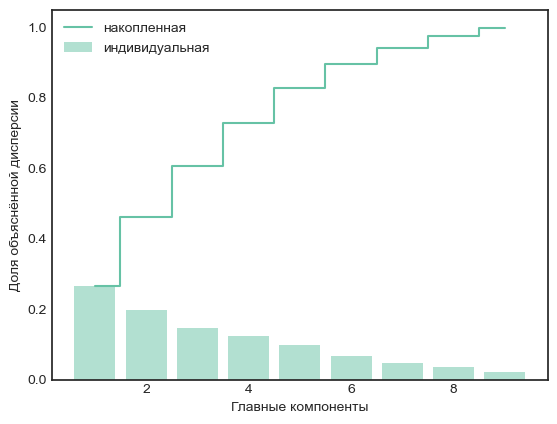

In [27]:
# график объяснённой дисперсии
plt.bar(range(1, 10), pca.explained_variance_ratio_, alpha=0.5, 
        align='center', label='индивидуальная')
plt.step(range(1, 10), np.cumsum(pca.explained_variance_ratio_), 
         where='mid', label='накопленная')
plt.ylabel('Доля объяснённой дисперсии')
plt.xlabel('Главные компоненты')
plt.legend()
plt.show()

Столбцы на графике показывают долю исходной дисперсии исходных переменных, которую объясняет главная компонента. Линией показана накопленная доля. Так, видно, что первые 5 компонент объясняют 80% исходной дисперсии $X$.   
Чтобы увидеть, как классы выглядят в координатах ГК на графике, придётся сократить пространство для двух компонент, которые объясняют 56% разброса объясняющих переменных.   

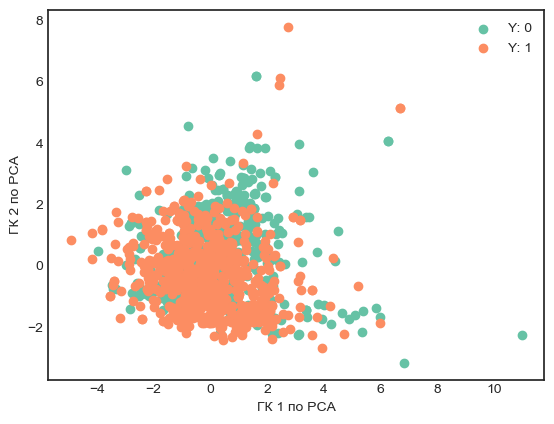

In [28]:
# пересчитываем X в 2 ГК
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)

# график классов в пространстве ГК
plt.scatter(X_train_pca[DF['Y'] == 0][:, 0], 
            X_train_pca[DF['Y'] == 0][:, 1], label='Y: 0')
plt.scatter(X_train_pca[DF['Y'] == 1][:, 0], 
            X_train_pca[DF['Y'] == 1][:, 1], label='Y: 1')
plt.xlabel('ГК 1 по PCA')
plt.ylabel('ГК 2 по PCA')
plt.legend()
plt.show()

Судя по графику, классы плохо разделяются в пространстве двух главных компонент. Построим логистическую регрессию и оценим её точность с помощью перекрёстной проверки.  

In [29]:
# функция оценки логистической регрессии
logit = LogisticRegression()
# функция разбиения на блоки для перекрёстной проверки
kf_10 = KFold(n_splits=10, random_state=my_seed, shuffle=True)
# считаем точность модели (Acc) с перекрёстной проверкой по блокам
score = list()
acc = cross_val_score(logit, X_train_pca, DF.Y.values, cv=kf_10,
                     scoring='accuracy').mean()
score.append(np.around(acc, 3))
score_models = list()
score_models.append('logit_PC2')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', np.around(score[0], 2), sep='')

Модель logit_PC2, перекрёстная проверка по 10 блокам
Acc = 0.6


In [30]:
cross_val_score?

# Методы сжатия  

## Ридж-регрессия  

Функция `LogisticRegression()` умеет работать с мультиклассовой классификацией, используя при оценке параметров подход **один класс против остальных**. Построим ридж на наших данных.  

In [32]:
# значения Y как метки классов
Y_train = DF.Y.values
# значения Y как фиктивные переменные
Y_train_dummy = pd.get_dummies(Y_train.astype(str))
# оцениваем
pca.fit(X_train_std, Y_train)
# функция для построения модели
logit_ridge = LogisticRegression(penalty='l2', solver='liblinear')
# оцениваем параметры
logit_ridge.fit(X_train_std, Y_train)
# выводим параметры
print('Константы моделей для классов:\n', np.around(logit_ridge.intercept_, 3),
     '\nКоэффициенты моделей для классов:\n', np.around(logit_ridge.coef_, 3))

Константы моделей для классов:
 [0.241] 
Коэффициенты моделей для классов:
 [[ 0.227  0.073 -0.34   0.338 -0.681 -0.125 -0.144  0.53   0.89 ]]


Подбираем гиперпараметр регуляризации $\lambda$ с помощью перекрёстной проверки. В функции 
`LogisticRegression()` есть аргумент $C$ – это инверсия гиперпараметра $\lambda$.   

In [33]:
# поиск оптимального значения C:
#  подбираем C по наибольшей точности с перекрёстной проверкой
ridge_cv = LogisticRegressionCV(cv=10, random_state=my_seed+2, 
                                penalty='l2', solver='liblinear')
ridge_cv.fit(X_train_std, Y_train)
# значения параметра C (инверсия лямбды), которые дают наилучшую
#  точность для каждого класса
ridge_cv.C_

array([0.04641589])

In [34]:
# сохраняем и выводим Acc для модели
score.append(np.around(ridge_cv.score(X_train_std, Y_train), 3))
score_models.append('logit_ridge')
print('Модель ', score_models[1], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', score[1], sep='')

Модель logit_ridge, перекрёстная проверка по 10 блокам
Acc = 0.726


Изобразим изменение коэффициентов ридж-регрессии на графике и сделаем отсечку на уровне оптимального параметра $C$.  

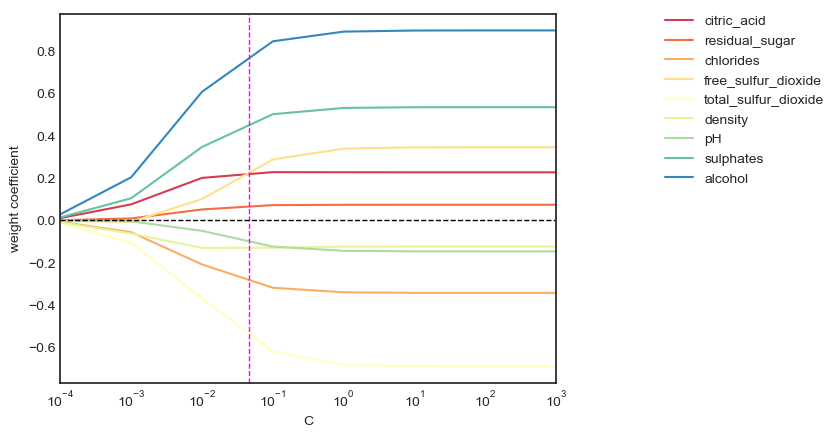

In [35]:
# график динамики коэффициентов в ридж-регрессии    
#  модель для класса 0
plot_coeffs_traces(X_train_std, Y_train, 0, 'l2', ridge_cv.C_, DF.columns)



# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [37]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,logit_PC2,0.595
1,logit_ridge,0.726


  Вторая модель показывает более высокую точность по показателю  $Acc$, 
наиболее точной оказывается ридж-регрессия. Сделаем прогноз на отложенные наблюдения.

In [38]:
# формируем объекты с данными отложенной выборки
X_pred_std = sc.fit_transform(DF_predict.iloc[:, :9].values)
Y_pred = DF_predict.Y
Y_hat = logit_ridge.predict(X_pred_std)
# отчёт по точности на отложенных наблюдениях
print(classification_report(Y_pred, Y_hat))

              precision    recall  f1-score   support

           0       0.70      0.71      0.70       113
           1       0.74      0.72      0.73       127

    accuracy                           0.72       240
   macro avg       0.72      0.72      0.72       240
weighted avg       0.72      0.72      0.72       240



Итак, методом логистической регрессии со сжатием, мы получили наиболее точную модель классификации двух видов.  